# IllustrisTNG : Mass Density to Lenstronomy Simulation Pipeline

In [41]:
# import of standard python libraries
import numpy as np
import os
import time
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd

import lenstronomy


# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

#import emcee for MCMC
import emcee

#import corner module with relevant installations for implementation
import corner


In [42]:
# Load the IllustrisTNG data

galaxy_data = pd.read_pickle('outputs/galaxy_data.pkl')

print("Available keys in galaxy_data:")
if 'galaxy_data' in locals():
    print(list(galaxy_data.keys()))

galaxy_component_data = pd.read_pickle('outputs/galaxy_component_data.pkl')
print("Available keys in galaxy_component_data:")
if 'galaxy_component_data' in locals():
    print(list(galaxy_component_data.keys()))

Available keys in galaxy_data:
['positions', 'masses', 'x_offset', 'y_offset', 'z_offset', 'histogram_2d', 'histogram_2d_log', 'xedges', 'yedges', 'range_kpc', 'bins']
Available keys in galaxy_component_data:
['stellar', 'dm', 'gas', 'total_zoom']


Creating 60 kpc cutoff mass density plot...
Particles within 60.0 kpc: 302,594 out of 1,337,538
Total mass within 60.0 kpc: 1.289e+12 M_sun


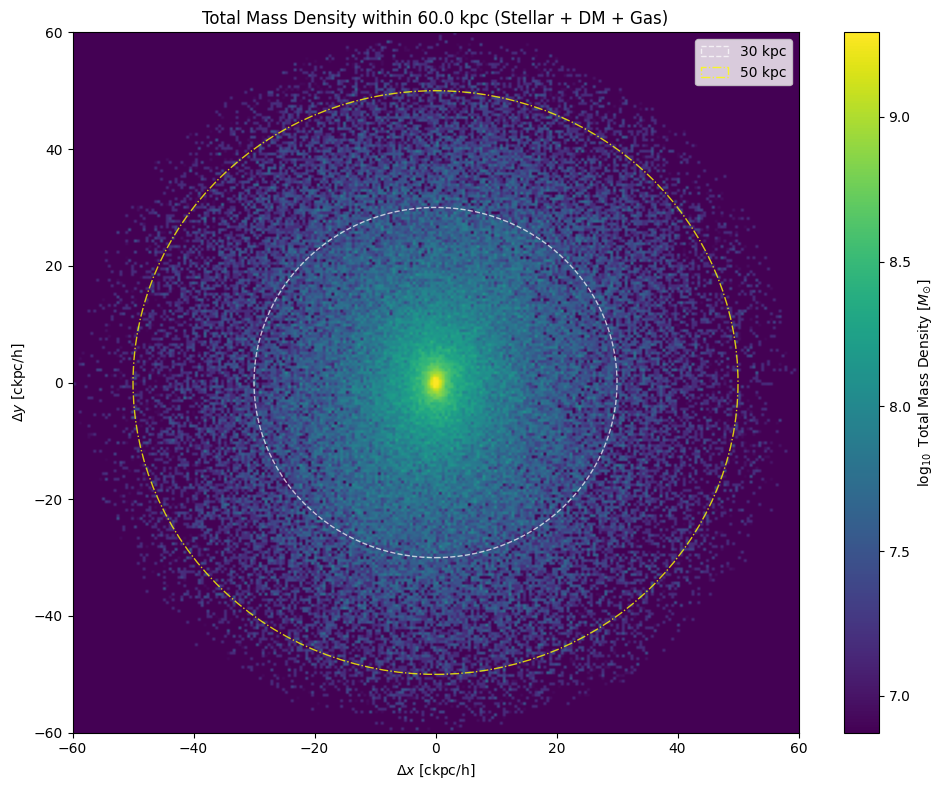


60 kpc cutoff data stored in 'galaxy_data_60kpc' dictionary


In [50]:
# Create a 60 kpc cutoff version of the mass density plot
print("Creating 60 kpc cutoff mass density plot...")

# Get the particle positions and masses from the loaded data
all_positions = galaxy_data['positions']
all_masses = galaxy_data['masses']
x_all = galaxy_data['x_offset']
y_all = galaxy_data['y_offset']
z_all = galaxy_data['z_offset']

# Calculate distances from the subhalo center for each particle
distances = np.sqrt(x_all**2 + y_all**2 + z_all**2)

# Select only particles within 60 kpc
radius_cutoff = 60.0  # kpc
within_60kpc = distances <= radius_cutoff

# Filter the positions and masses
x_60kpc = x_all[within_60kpc]
y_60kpc = y_all[within_60kpc]
masses_60kpc = all_masses[within_60kpc]

print(f"Particles within {radius_cutoff} kpc: {len(masses_60kpc):,} out of {len(all_masses):,}")
print(f"Total mass within {radius_cutoff} kpc: {np.sum(masses_60kpc):.3e} M_sun")

# Create 2D histogram with 60 kpc range
range_60kpc = [[-60, 60], [-60, 60]]  # kpc range
bins_60kpc = [250, 250]  # bin resolution

hist_60kpc, xedges_60, yedges_60 = np.histogram2d(
    x_60kpc, y_60kpc,
    range=range_60kpc,
    bins=bins_60kpc,
    weights=masses_60kpc
)

# Mask zero values for log transformation
w0_60 = hist_60kpc > 0

# Apply log10 transformation safely
hist_60kpc_log = np.copy(hist_60kpc)
hist_60kpc_log[w0_60] = np.log10(hist_60kpc_log[w0_60])

# Compute vmin and vmax using percentiles
vmin_60, vmax_60 = np.percentile(hist_60kpc_log[w0_60], [5, 99.99])

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

im = ax.imshow(hist_60kpc_log.T, origin='lower',
               extent=[xedges_60[0], xedges_60[-1], yedges_60[0], yedges_60[-1]],
               vmin=vmin_60, vmax=vmax_60, aspect='auto', cmap='viridis')

plt.colorbar(im, ax=ax, label=r'$\log_{10}$ Total Mass Density [$M_{\odot}$]')
ax.set_xlabel(r'$\Delta x$ [ckpc/h]')
ax.set_ylabel(r'$\Delta y$ [ckpc/h]')
ax.set_title(f'Total Mass Density within {radius_cutoff} kpc (Stellar + DM + Gas)')

# Add reference circles
circle_30 = plt.Circle((0, 0), 30, fill=False, color='white',
                      linestyle='--', linewidth=1, alpha=0.7, label='30 kpc')
circle_50 = plt.Circle((0, 0), 50, fill=False, color='yellow',
                      linestyle='-.', linewidth=1, alpha=0.8, label='50 kpc')
ax.add_patch(circle_30)
ax.add_patch(circle_50)
ax.legend()

plt.tight_layout()
plt.show()

# Store the 60 kpc data for further use
galaxy_data_60kpc = {
    'histogram_2d': hist_60kpc,
    'histogram_2d_log': hist_60kpc_log,
    'xedges': xedges_60,
    'yedges': yedges_60,
    'range_kpc': range_60kpc,
    'bins': bins_60kpc,
    'total_mass': np.sum(masses_60kpc),
    'n_particles': len(masses_60kpc)
}

print(f"\n60 kpc cutoff data stored in 'galaxy_data_60kpc' dictionary")

Creating 2x2 grid of component plots with 60 kpc cutoff...
STELLAR: 1.454e+11 M_sun within 60 kpc
DM: 2.004e+12 M_sun within 60 kpc
GAS: 3.241e+10 M_sun within 60 kpc
TOTAL_ZOOM: 2.182e+12 M_sun within 60 kpc


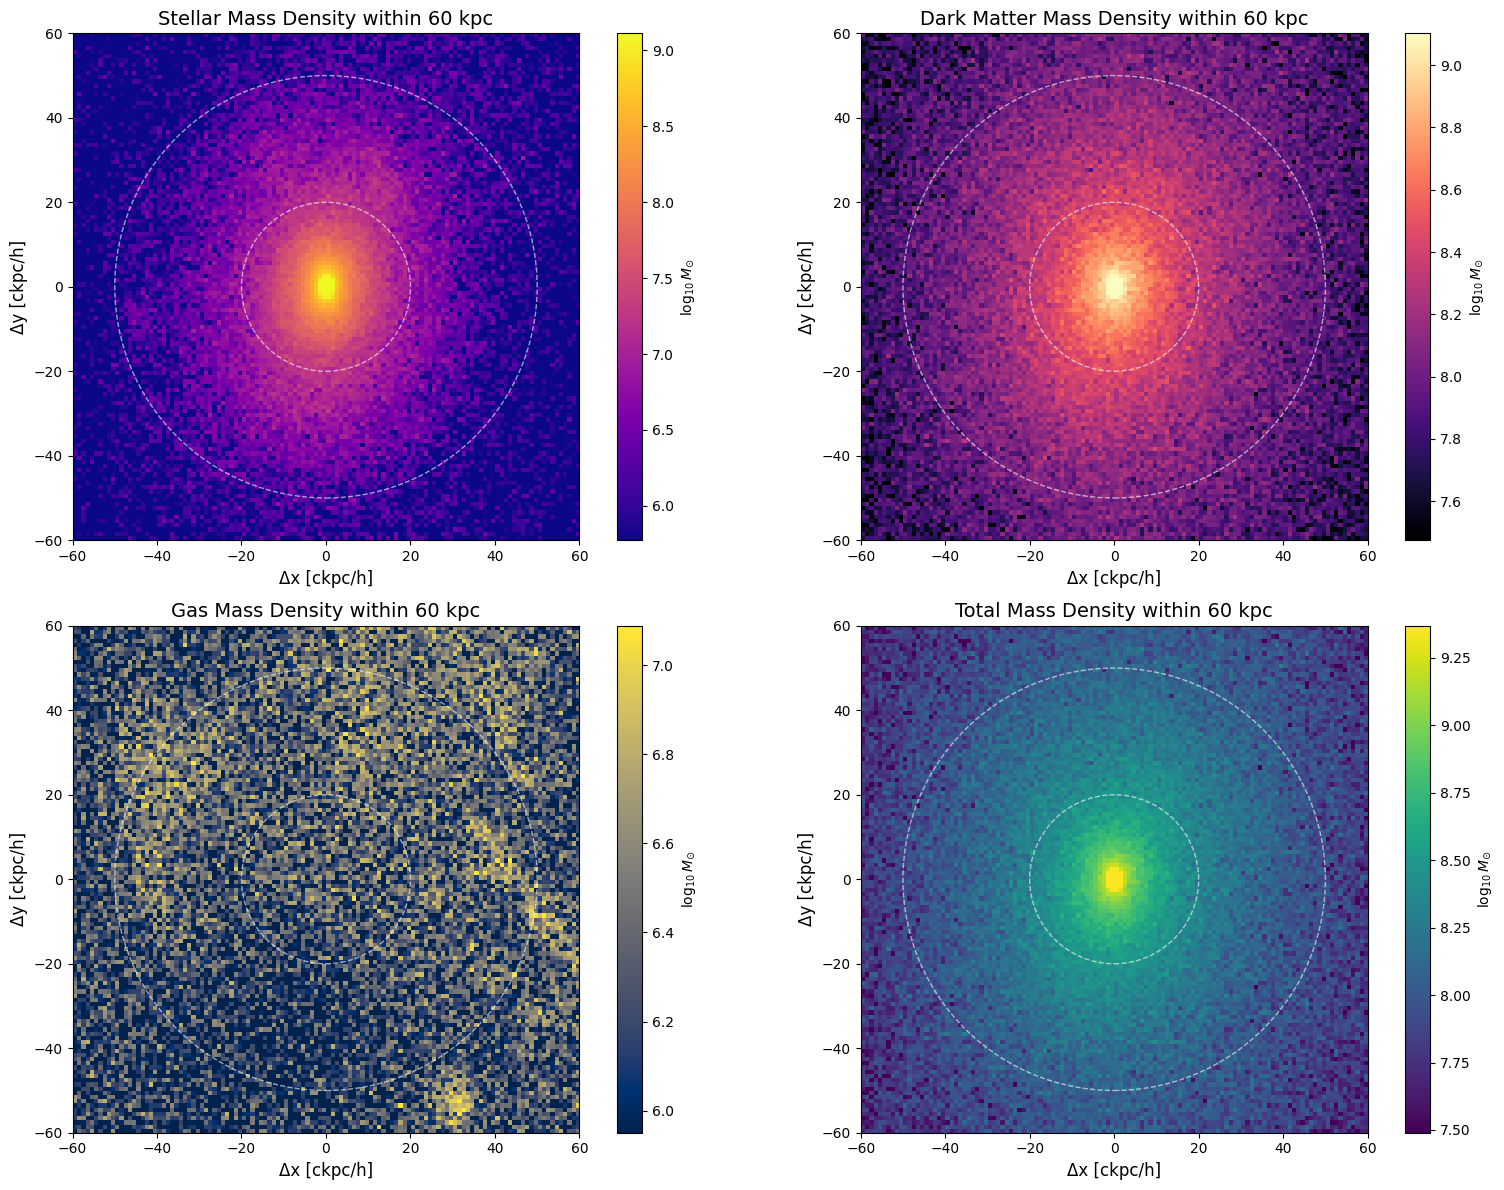


All component plots completed in 2x2 grid layout.


In [51]:
# Create a 2x2 grid layout for all components with 60 kpc cutoff
print("Creating 2x2 grid of component plots with 60 kpc cutoff...")

# Component settings
components = ['stellar', 'dm', 'gas', 'total_zoom']
component_settings = {
    'stellar': {'title': 'Stellar Mass Density', 'cmap': 'plasma'},
    'dm': {'title': 'Dark Matter Mass Density', 'cmap': 'magma'},
    'gas': {'title': 'Gas Mass Density', 'cmap': 'cividis'},
    'total_zoom': {'title': 'Total Mass Density', 'cmap': 'viridis'}
}

radius_cutoff = 60  # kpc

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten to make indexing easier

for i, comp in enumerate(components):
    ax = axes[i]
    settings = component_settings[comp]
    
    # Get the component data
    comp_data = galaxy_component_data[comp]
    hist_full = comp_data['hist']
    hist_log_full = comp_data['hist_log']
    xe_full, ye_full = comp_data['edges']
    
    # Create index arrays for the cutoff
    x_centers = (xe_full[:-1] + xe_full[1:]) / 2
    y_centers = (ye_full[:-1] + ye_full[1:]) / 2
    
    # Find indices within the radius cutoff
    x_mask = np.abs(x_centers) <= radius_cutoff
    y_mask = np.abs(y_centers) <= radius_cutoff
    
    # Extract the subset
    hist_subset = hist_full[x_mask, :][:, y_mask]
    hist_log_subset = hist_log_full[x_mask, :][:, y_mask]
    
    # Create new edges for the subset
    x_idx = np.where(x_mask)[0]
    y_idx = np.where(y_mask)[0]
    xe_subset = xe_full[x_idx[0]:x_idx[-1]+2]
    ye_subset = ye_full[y_idx[0]:y_idx[-1]+2]
    
    # Mask for non-zero values
    w0 = hist_subset > 0
    
    if np.sum(w0) > 0:
        # Compute vmin and vmax using percentiles
        vmin, vmax = np.percentile(hist_log_subset[w0], [1, 99.9])
        
        # Create the image
        im = ax.imshow(hist_log_subset.T, origin='lower',
                       extent=[xe_subset[0], xe_subset[-1], ye_subset[0], ye_subset[-1]],
                       vmin=vmin, vmax=vmax, cmap=settings['cmap'])
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label=r'$\log_{10} M_{\odot}$')
        
        # Add reference circles
        for r in [20, 50]:
            if r < radius_cutoff:
                circle = plt.Circle((0, 0), r, fill=False, color='white',
                                  linestyle='--', linewidth=1, alpha=0.6)
                ax.add_patch(circle)
        
        # Print statistics
        total_mass = np.sum(hist_subset)
        print(f"{comp.upper()}: {total_mass:.3e} M_sun within {radius_cutoff} kpc")
        
    else:
        print(f"No data found within {radius_cutoff} kpc for {comp}")
    
    # Labels and title
    ax.set_title(f"{settings['title']} within {radius_cutoff} kpc", fontsize=14)
    ax.set_xlabel('Δx [ckpc/h]', fontsize=12)
    ax.set_ylabel('Δy [ckpc/h]', fontsize=12)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"\nAll component plots completed in 2x2 grid layout.")

In [53]:
# Calculate angular pixel size in arcseconds for z=0.5 galaxy
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

print("Calculating angular pixel size for IllustrisTNG galaxy at z=0.5")
print("=" * 60)

# TNG cosmology parameters
H0 = 67.74  # km/s/Mpc (from TNG)
h = 0.6774  # Dimensionless Hubble parameter
Om0 = 0.3089  # Matter density parameter
Ode0 = 0.6911  # Dark energy density parameter

# Create cosmology object
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

# Galaxy redshift
z_galaxy = 0.5

# Angular diameter distance to the galaxy
D_A = cosmo.angular_diameter_distance(z_galaxy)
print(f"Angular diameter distance at z={z_galaxy}: {D_A:.1f}")

# Physical pixel size from the histogram
# From 3rd cell: range_60kpc = [[-60, 60], [-60, 60]] with bins_60kpc = [200, 200]
physical_range = 120  # kpc (from -60 to +60)
n_pixels = 250
pixel_size_kpc = physical_range / n_pixels

print(f"Physical pixel size: {pixel_size_kpc} kpc")

# Convert to angular size using astropy's built-in functionality
# Angular size = physical size / angular diameter distance
angular_size_arcsec = (pixel_size_kpc * u.kpc / D_A * u.radian).to(u.arcsec)

print(f"Angular pixel size: {angular_size_arcsec:.3f}")


# # For comparison with typical observations
# print(f"\nComparison with typical observations:")
# print(f"• HST/WFC3 pixel scale: ~0.13 arcsec/pixel")
# print(f"• JWST/NIRCam pixel scale: ~0.031 arcsec/pixel (short wavelength)")
# print(f"• Ground-based seeing: ~0.5-1.5 arcsec")
# print(f"• Your TNG pixel: {angular_size_arcsec:.3f}")

# # Calculate how many TNG pixels correspond to typical scales
# hst_pixels_per_tng = (0.13 * u.arcsec / angular_size_arcsec)
# print(f"\nScale comparison:")
# print(f"• {hst_pixels_per_tng:.1f} HST pixels = 1 TNG pixel")
# print(f"• 1 TNG pixel = {1/hst_pixels_per_tng:.1f} HST pixels")

# # Physical scale at different redshifts for reference
# print(f"\nPhysical scale of {pixel_size_kpc} kpc at different redshifts:")
# for z in [0.2, 0.5, 1.0, 2.0]:
#     D_A_z = cosmo.angular_diameter_distance(z)
#     ang_size_z = (pixel_size_kpc * u.kpc / D_A_z * u.radian).to(u.arcsec)
#     print(f"  z={z}: {ang_size_z:.3f}")

# print(f"\nConclusion: Your TNG histogram has excellent resolution for strong lensing!")
# print(f"Each pixel is {angular_size_arcsec:.3f}, which is well-suited for modeling")
# print(f"Einstein rings and lensing arcs in HST-quality observations.")

Calculating angular pixel size for IllustrisTNG galaxy at z=0.5
Angular diameter distance at z=0.5: 1297.1 Mpc
Physical pixel size: 0.48 kpc
Angular pixel size: 0.076 arcsec


### Compute the lensing galaxy convergence

Computing lensing convergence (κ) from IllustrisTNG galaxy...
Angular diameter distances:
D_l (lens at z=0.5): 1297.1 Mpc
D_s (source at z=1.2): 1757.4 Mpc
D_ls (lens-source): 873.0 Mpc

Critical surface density:
Σ_crit = 2.581e+09 solMass / kpc2

Surface mass density statistics:
Pixel area: 0.2304 kpc²
Total mass in map: 1.289e+12 M_sun
Max surface density: 1.086e+10 M_sun/kpc²
Min surface density: 0.000e+00 M_sun/kpc²

Convergence (κ) statistics:
Max κ: 4.2095
Min κ: 0.0000
Mean κ: 0.0347
κ > 1 (strong lensing): 52 pixels
κ > 0.5: 167 pixels


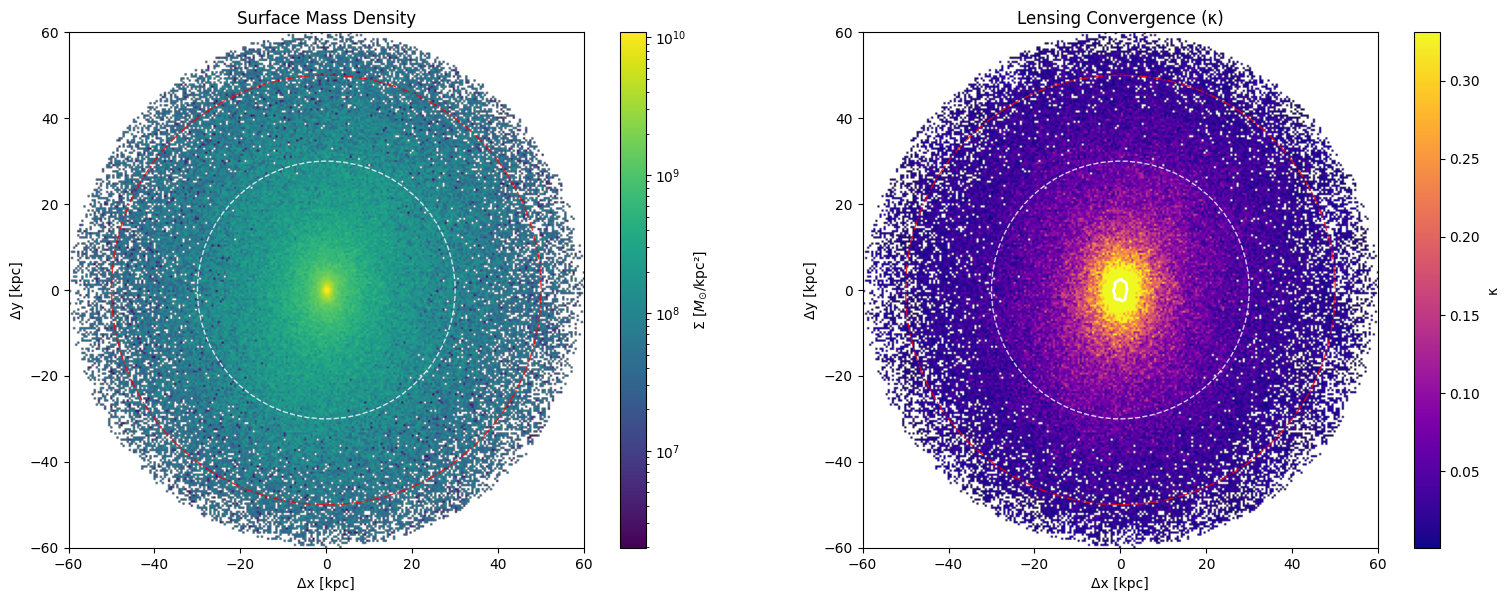


Convergence data stored in 'convergence_data' dictionary
Ready for lenstronomy INTERPOL class!


In [64]:
# Compute lensing convergence (κ) from 2D surface mass density
from matplotlib.colors import LogNorm
print("Computing lensing convergence (κ) from IllustrisTNG galaxy...")
print("=" * 60)

# Cosmological and lensing parameters
z_lens = 0.5    # Lens (galaxy) redshift
z_source = 1.2  # Source redshift (background galaxy/quasar)

# Angular diameter distances using TNG cosmology
D_l = cosmo.angular_diameter_distance(z_lens)     # Distance to lens
D_s = cosmo.angular_diameter_distance(z_source)   # Distance to source  
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)  # Lens-source distance

print(f"Angular diameter distances:")
print(f"D_l (lens at z={z_lens}): {D_l:.1f}")
print(f"D_s (source at z={z_source}): {D_s:.1f}")
print(f"D_ls (lens-source): {D_ls:.1f}")

# Critical surface density for lensing
# Σ_crit = (c²/4πG) × (D_s)/(D_l × D_ls)
from astropy import constants as const

c = const.c  # Speed of light
G = const.G  # Gravitational constant

# Calculate critical surface density
Sigma_crit = (c**2 / (4 * np.pi * G)) * (D_s / (D_l * D_ls))
Sigma_crit = Sigma_crit.to(u.Msun / u.kpc**2)  # Convert to solar masses per kpc²

print(f"\nCritical surface density:")
print(f"Σ_crit = {Sigma_crit:.3e}")

# Get the 2D surface mass density from our histogram (NOT the log version!)
surface_mass_density = galaxy_data_60kpc['histogram_2d']  # M_sun per bin
pixel_area_kpc2 = (pixel_size_kpc)**2  # kpc² per pixel

# Convert from total mass per bin to surface mass density (M_sun/kpc²)
surface_density_map = surface_mass_density / pixel_area_kpc2  # M_sun/kpc²

print(f"\nSurface mass density statistics:")
print(f"Pixel area: {pixel_area_kpc2:.4f} kpc²")
print(f"Total mass in map: {np.sum(surface_mass_density):.3e} M_sun")
print(f"Max surface density: {np.max(surface_density_map):.3e} M_sun/kpc²")
print(f"Min surface density: {np.min(surface_density_map):.3e} M_sun/kpc²")

# Compute convergence κ = Σ(x,y) / Σ_crit
kappa_map = surface_density_map / Sigma_crit.value

print(f"\nConvergence (κ) statistics:")
print(f"Max κ: {np.max(kappa_map):.4f}")
print(f"Min κ: {np.min(kappa_map):.4f}")
print(f"Mean κ: {np.mean(kappa_map):.4f}")
print(f"κ > 1 (strong lensing): {np.sum(kappa_map > 1)} pixels")
print(f"κ > 0.5: {np.sum(kappa_map > 0.5)} pixels")

# Create visualization of convergence map
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Surface mass density
im1 = axes[0].imshow(surface_density_map.T, origin='lower',
                     extent=[xedges_60[0], xedges_60[-1], yedges_60[0], yedges_60[-1]],
                     cmap='viridis', norm=LogNorm())
axes[0].set_title('Surface Mass Density')
axes[0].set_xlabel('Δx [kpc]')
axes[0].set_ylabel('Δy [kpc]')
plt.colorbar(im1, ax=axes[0], label=r'Σ [$M_{\odot}$/kpc²]')

# Add reference circles
for ax in axes:
    circle_30 = plt.Circle((0, 0), 30, fill=False, color='white',
                          linestyle='--', linewidth=1, alpha=0.8)
    circle_50 = plt.Circle((0, 0), 50, fill=False, color='red',
                          linestyle='-.', linewidth=1, alpha=0.8)
    ax.add_patch(circle_30)
    ax.add_patch(circle_50)

# Plot 2: Convergence map
# Mask zero values for better visualization
kappa_masked = np.copy(kappa_map)
kappa_masked[kappa_masked <= 0] = np.nan

im2 = axes[1].imshow(kappa_masked.T, origin='lower',
                     extent=[xedges_60[0], xedges_60[-1], yedges_60[0], yedges_60[-1]],
                     cmap='plasma', vmin=0.001, vmax=np.percentile(kappa_map[kappa_map > 0], 99))
axes[1].set_title('Lensing Convergence (κ)')
axes[1].set_xlabel('Δx [kpc]')
axes[1].set_ylabel('Δy [kpc]')
plt.colorbar(im2, ax=axes[1], label='κ')

# Add critical curves (κ = 1) as contours
axes[1].contour(kappa_map.T, levels=[1.0], colors='white', linewidths=2,
                extent=[xedges_60[0], xedges_60[-1], yedges_60[0], yedges_60[-1]])

plt.tight_layout()
plt.show()

# Store convergence data for lenstronomy
convergence_data = {
    'kappa_map': kappa_map,
    'surface_density_map': surface_density_map,
    'Sigma_crit': Sigma_crit.value,
    'z_lens': z_lens,
    'z_source': z_source,
    'D_l': D_l.value,
    'D_s': D_s.value,
    'D_ls': D_ls.value,
    'pixel_size_kpc': pixel_size_kpc,
    'xedges': xedges_60,
    'yedges': yedges_60
}

print(f"\nConvergence data stored in 'convergence_data' dictionary")
print(f"Ready for lenstronomy INTERPOL class!")

In [ ]:

from matplotlib.colors import LogNorm
print("Computing lensing convergence (κ) from IllustrisTNG galaxy...")
print("=" * 60)

# Cosmological and lensing parameters
z_lens = 0.5    # Lens (galaxy) redshift
z_source = 1.2  # Source redshift (background galaxy/quasar)

# Angular diameter distances using TNG cosmology
D_l = cosmo.angular_diameter_distance(z_lens)     # Distance to lens
D_s = cosmo.angular_diameter_distance(z_source)   # Distance to source  
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)  # Lens-source distance

print(f"Angular diameter distances:")
print(f"D_l (lens at z={z_lens}): {D_l:.1f}")
print(f"D_s (source at z={z_source}): {D_s:.1f}")
print(f"D_ls (lens-source): {D_ls:.1f}")

# Critical surface density for lensing
# Σ_crit = (c²/4πG) × (D_s)/(D_l × D_ls)
from astropy import constants as const

c = const.c  # Speed of light
G = const.G  # Gravitational constant

# Calculate critical surface density
Sigma_crit = (c**2 / (4 * np.pi * G)) * (D_s / (D_l * D_ls))
Sigma_crit = Sigma_crit.to(u.Msun / u.kpc**2)  # Convert to solar masses per kpc²

print(f"\nCritical surface density:")
print(f"Σ_crit = {Sigma_crit:.3e}")

# Get the 2D surface mass density from our histogram (NOT the log version!)
surface_mass_density = galaxy_data_60kpc['histogram_2d']  # M_sun per bin
pixel_area_kpc2 = (pixel_size_kpc)**2  # kpc² per pixel

# Convert from total mass per bin to surface mass density (M_sun/kpc²)
surface_density_map = surface_mass_density / pixel_area_kpc2  # M_sun/kpc²

print(f"\nSurface mass density statistics:")
print(f"Pixel area: {pixel_area_kpc2:.4f} kpc²")
print(f"Total mass in map: {np.sum(surface_mass_density):.3e} M_sun")
print(f"Max surface density: {np.max(surface_density_map):.3e} M_sun/kpc²")
print(f"Min surface density: {np.min(surface_density_map):.3e} M_sun/kpc²")

# Compute convergence κ = Σ(x,y) / Σ_crit
kappa_map = surface_density_map / Sigma_crit.value

print(f"\nConvergence (κ) statistics:")
print(f"Max κ: {np.max(kappa_map):.4f}")
print(f"Min κ: {np.min(kappa_map):.4f}")
print(f"Mean κ: {np.mean(kappa_map):.4f}")
print(f"κ > 1 (strong lensing): {np.sum(kappa_map > 1)} pixels")
print(f"κ > 0.5: {np.sum(kappa_map > 0.5)} pixels")

# Create visualization of convergence map
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Surface mass density
im1 = axes[0].imshow(surface_density_map.T, origin='lower',
                     extent=[xedges_60[0], xedges_60[-1], yedges_60[0], yedges_60[-1]],
                     cmap='viridis', norm=LogNorm())
axes[0].set_title('Surface Mass Density')
axes[0].set_xlabel('Δx [kpc]')
axes[0].set_ylabel('Δy [kpc]')
plt.colorbar(im1, ax=axes[0], label=r'Σ [$M_{\odot}$/kpc²]')

# Add reference circles
for ax in axes:
    circle_30 = plt.Circle((0, 0), 30, fill=False, color='white',
                          linestyle='--', linewidth=1, alpha=0.8)
    circle_50 = plt.Circle((0, 0), 50, fill=False, color='red',
                          linestyle='-.', linewidth=1, alpha=0.8)
    ax.add_patch(circle_30)
    ax.add_patch(circle_50)

# Plot 2: Convergence map
# Mask zero values for better visualization
kappa_masked = np.copy(kappa_map)
kappa_masked[kappa_masked <= 0] = np.nan

im2 = axes[1].imshow(kappa_masked.T, origin='lower',
                     extent=[xedges_60[0], xedges_60[-1], yedges_60[0], yedges_60[-1]],
                     cmap='plasma', vmin=0.001, vmax=np.percentile(kappa_map[kappa_map > 0], 99))
axes[1].set_title('Lensing Convergence (κ)')
axes[1].set_xlabel('Δx [kpc]')
axes[1].set_ylabel('Δy [kpc]')
plt.colorbar(im2, ax=axes[1], label='κ')

# Add critical lines (κ = 1)
contour = axes[1].contour(kappa_map.T, levels=[1.0], colors='red', linewidths=2,
                         extent=[xedges_60[0], xedges_60[-1], yedges_60[0], yedges_60[-1]])
axes[1].clabel(contour, inline=True, fontsize=10, fmt='κ=%.1f')

plt.tight_layout()
plt.show()

# Store convergence data
convergence_data = {
    'kappa_map': kappa_map,
    'surface_density_map': surface_density_map,
    'Sigma_crit': Sigma_crit.value,
    'z_lens': z_lens,
    'z_source': z_source,
    'D_l': D_l.value,
    'D_s': D_s.value,
    'D_ls': D_ls.value,
    'pixel_size_kpc': pixel_size_kpc,
    'xedges': xedges_60,
    'yedges': yedges_60
}

print(f"\nConvergence data stored in 'convergence_data' dictionary")
print(f"Ready for lenstronomy INTERPOL class!")

In [ ]:
Delta_pix = round(angular_size_arcsec.to(u.arcsec).value, 5)
numPix = 250  # from the histogram settings
